# Attention is All You Need
Over the next two final exercise, we are going to put together a transformer model from scratch! The most important building block, as the title of the paper might the suggest, is the attention block / mechanism! We are going to lay the ground works for exercise 12 in this exercise, to make sure you are familiar with the basics! The implementation will try to stick to the paper as closly as possible, so there is really no need to read it! But you are of course welcome to! So let's start this - and for you it's really time to pay attention!

## (Optional) Mount folder in Colab

Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [23]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_11) is given.

"""
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_11'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))
"""

"\nfrom google.colab import drive\nimport os\n\ngdrive_path='/content/gdrive/MyDrive/i2dl/exercise_11'\n\n# This will mount your google drive under 'MyDrive'\ndrive.mount('/content/gdrive', force_remount=True)\n# In order to access the files in this notebook we have to navigate to the correct folder\nos.chdir(gdrive_path)\n# Check manually if all files are present\nprint(sorted(os.listdir()))\n"

In [24]:
from exercise_code.util import notebook_util as util
from exercise_code.network import *
from exercise_code.tests import *
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Attention Mechanism

There are multiple ways of understanding how the attention mechanism works! In the last two semesters, we mainly used the "Improving Measurement" analgoy which is a lot more straightforwad. Some of you might prefer the second explanation right after this, comparing attention to a detective mistery. This is optional to read! Please let us know, in the feedback form at the end of the exercise, which of the two you prefered or if you found the combination of both to be the best way to go!

### Improving Noisy Measurements
Imagine you have taken some measurement x(t), but notice that it is quite noisy:

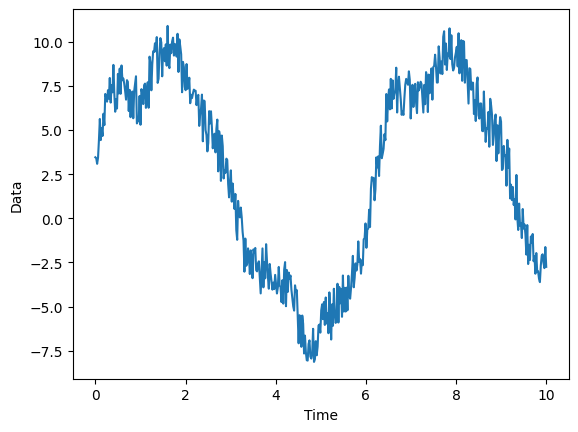

In [25]:
measurement_data = util.get_measurement_data()
plt.plot(measurement_data['time'], measurement_data['data_noise'])
plt.xlabel('Time'), plt.ylabel('Data')
plt.show()

So a way we could try to improve these measurements is by smoothing out the values using a weighted average:


$\tilde{x}_i = \sum_{j=1}^N s_{ij} x_j$

We could base the weights on a similarity score between the time stamps. Values that are closer together time-wise, should have a larger impact/weight compared to values that are further apart!

$s_{ij} = sim(t_i, t_j)$

A possible option as a similarity function is the squared exponential kernel:

$sim(t_i, t_j) = \exp\left(-\frac{(t_i - t_j)^2}{\sigma ^2}\right)$

Let's have a look at the similarity function:

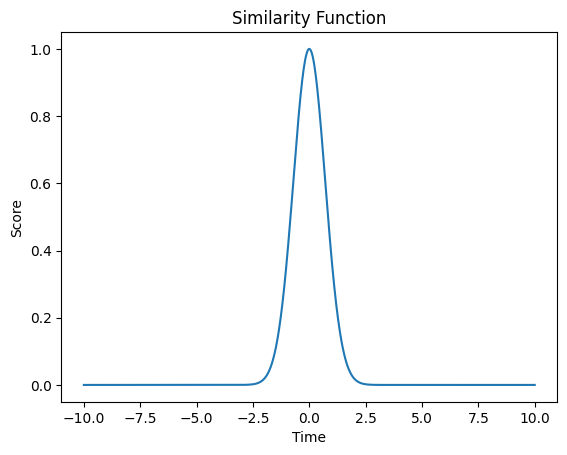

In [26]:
# Define the squared exponential kernel 
def similarity(x1, x2):
    sigma = 1
    return np.exp(-((x1 - x2)**2 / (sigma ** 2)))

# Define the time stamps
time_stamps = np.linspace(-10, 10, 1000)

# Compute the similarity scores between 0 and all other time stamps
scores = similarity(0, time_stamps)

# Plot the similarity scores
plt.plot(time_stamps, scores)
plt.title('Similarity Function')
plt.xlabel('Time'), plt.ylabel('Score')
plt.show()

As you can see, the closer we get to the zero, the higher the score gets!
With a little bit of index magic, we can calculate the score for every single time pair $(t_i, t_j)$ in one step! We will store all of these in a score matrix: 

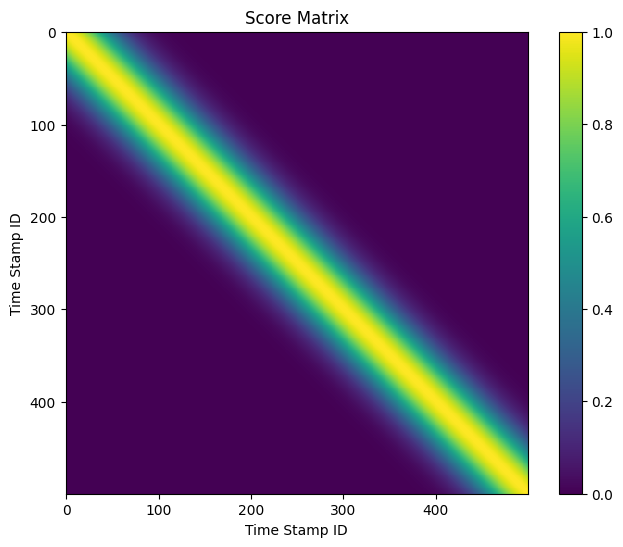

In [27]:
# Get the actual timestamps from the measurement data
time_stamps = measurement_data['time']

# Compute the similarity scores between all time stamps
scores = similarity(time_stamps[:, None], time_stamps[None, :])

# Plot the similarity scores
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest')
plt.title('Score Matrix')
plt.colorbar()
plt.xlabel('Time Stamp ID'), plt.ylabel('Time Stamp ID')
plt.show()

What you should see a high value along the diagonal, and the values decrease the further you move away from the diagonal. 

Next, let's compute these averages! Note, that the average can also be described very efficiently as a Matrix-Vector product using the score matrix we calculated before:

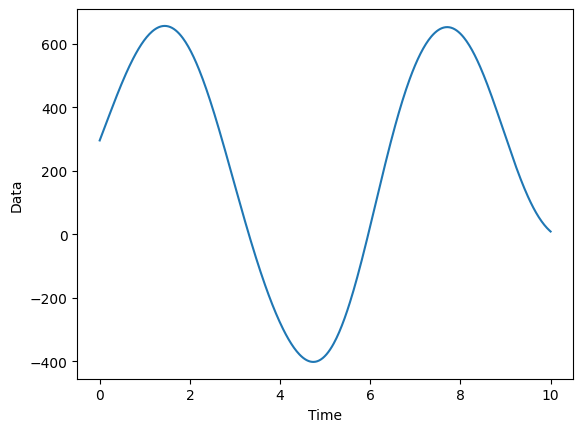

In [28]:
# Compute filtered data
filter_data = scores @ measurement_data['data_noise']

# Plot the filtered data
plt.plot(time_stamps, filter_data)
plt.xlabel('Time'), plt.ylabel('Data')
plt.show()

Looks a lot better! However, we are actually filtering out a lot of the underlying signal. Try changing sigma in the next cell to a different values (e.g $\sigma = 0.5$ or even $\sigma = 0.1$) and have a look at the function!

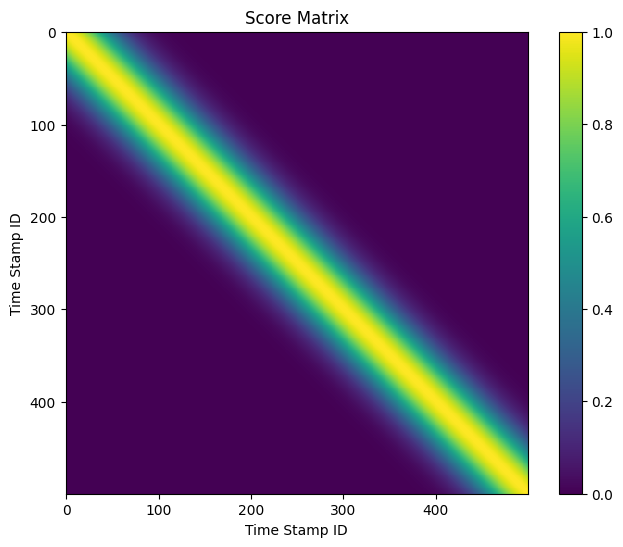

In [29]:
# Edit Sigma here
sigma = 1.0

def similarity(x1, x2):
    return np.exp(-((x1 - x2)**2 / (sigma ** 2)))

# Compute the similarity scores between all time stamps
scores = similarity(time_stamps[:, None], time_stamps[None, :])

# Plot the similarity scores
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest')
plt.title('Score Matrix')
plt.colorbar()
plt.xlabel('Time Stamp ID'), plt.ylabel('Time Stamp ID')
plt.show()

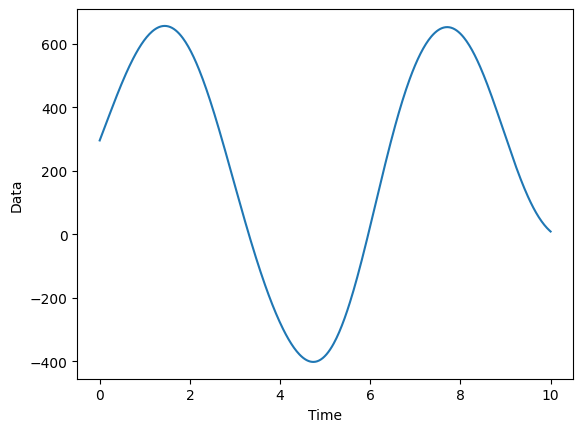

In [30]:
# Compute filtered data
filter_data = scores @ measurement_data['data_noise']

# Plot the filtered data
plt.plot(time_stamps, filter_data)
plt.xlabel('Time'), plt.ylabel('Data')
plt.show()

If you did it then - Nice! We are not loosing that much information anymore! If not - Come on, it's like only one line ;P

We still have one problem in our implementation: If you have a look at the scale of our data, it has changed quite a bit!

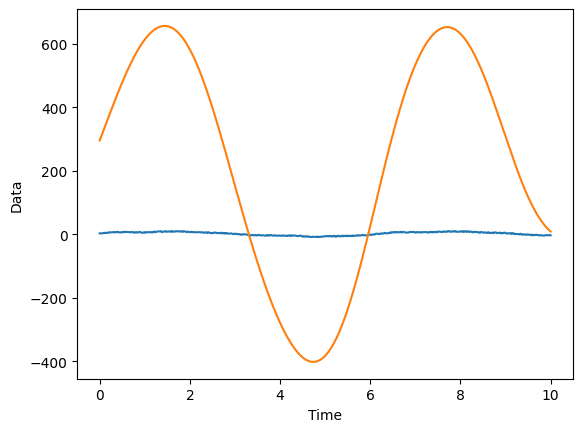

In [31]:
# Plot filtered data and the original measurement data
plt.figure()
plt.plot(time_stamps, measurement_data['data_noise'])
plt.plot(time_stamps, filter_data)
plt.xlabel('Time'), plt.ylabel('Data')
plt.show()

We can somewhat improve this by normalizing our scores to sum up to one.

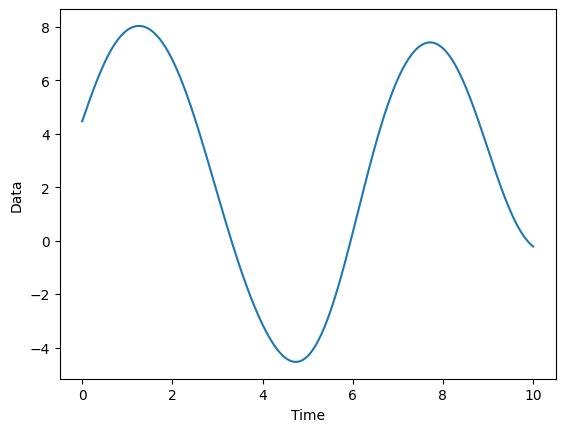

In [32]:
# Normaliize scores by dividing by the sum of all scores
scores_normalized = scores / np.sum(scores, axis=0)

# Calculate the filtered data again using the normalized weights
filter_data = scores_normalized @ measurement_data['data_noise']

# Plot the filtered data
plt.plot(time_stamps, filter_data)
plt.xlabel('Time'), plt.ylabel('Data')
plt.show()

Now the scales should match a lot better!

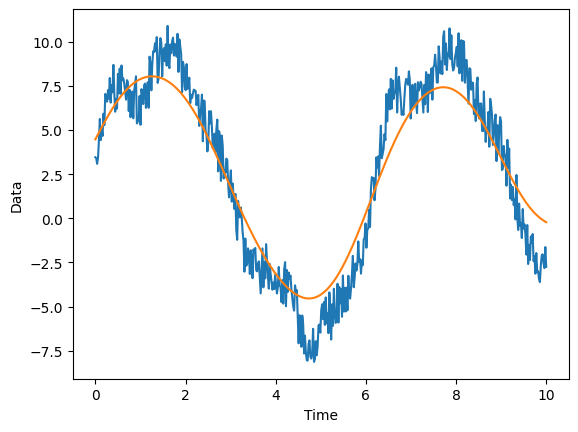

In [33]:
# Plot filtered data with normalized scores and the original measurement data
plt.figure()
plt.plot(time_stamps, measurement_data['data_noise'])
plt.plot(time_stamps, filter_data)
plt.xlabel('Time'), plt.ylabel('Data')
plt.show()

Another way of thinking about this, is that we have "improved" our data, by introducing context from other points to it, i.e. each datapoint looks at its neighboring datapoints. We can also introduce the terminology used in the paper: For every **query** (timestamp) $t_i$, compare it to all available **keys** $t_j$ (all other timestamps) and compute **similarity scores**. Multiply these scores with the corresponding **values** $x_j$ (the measurements) to form the "answer" to the query $t_i$. Note, that each key corresponds to a value!

Now let's see if we can find something similar for words. After all, thats what we want our model to work with.

### Applying Similarity-based Context to Word Embeddings

The concept of attention mirrors the method we used earlier:

When we transform a sentence into a sequence of embeddings $x_i$, translating each word independently may cause an issue: context matters!

Consider these sentences:
- The river bank is very long.
- The bank is located at the long river.

Both contain the word 'bank', but its meaning changes with context. Think about what this also means for the embeddings, which are supposed to "capture the meaning" of each word: The embedding for 'bank' should ideally differ in both sentences!

Our current implementation of the embedding layer does not take context (i.e. the other words in the sentence) into account, it simply maps each word to a vector from a static lookup table. Therefore, we need to find a way to **contextualize** the embeddings!

Before we get into the details we will again define a set of 

- Queries Q - Think of it as what the word is looking for
- Keys K - This is kind of like what the word looks like
- Values V - Basically what the word has to offer

These three vectors are in a way also embeddings (vector representations of words). We will discuss later on how we create them, but they are basically just a function of the origianl embeddings X.

With that beeing said, the simplest way to create contextualized embeddings, similar to before, is to take a weighted average of the embeddings of all words we want to get context from - our values $v_j$:

$\tilde{x}_i = \sum_{j=1}^N s_{ij} v_j$

We define the scores as before, by computing the similarity between the query $q_i$ and the keys $k_j$: 

$s_{ij} = \text{sim}(q_i, k_j)$

Does this make sense? The learned embeddings ideally represent similar words that co-occur or are semantically linked (like 'apple' and 'fruit'). Conversely, words with low co-occurrence, like 'computer' and 'elephant', should be dissimilar. So in way it does make sense, that "similar" words should contribute more to each other's context (but we will revisit this later).

Now, about the similarity function: instead of the squared exponential kernel, we use the dot product! But does the dot product truly measure similarity between vectors?

$\langle a,b \rangle = \cos(\angle_{ab})|a||b|$

We can see from here, that the closer two embeddings are, the higher the dot product will become! (Of course the norm of the vectors also affects the score)

Let's define the similarity function:

In [34]:
# Define similarity function as the inner product
def similarity(q, k):
    return np.inner(q, k)

We have prepared a pretrained embedding model for you, so you can play around with it!

In [35]:
# Load the word2vec model
word2vec = util.load_word2vec()

In [36]:
# Get the word vectors for apple and fruit
word_1 = word2vec['apple']
word_2 = word2vec['fruit']

q_1 = util.get_query(word_1)
k_2 = util.get_key(word_2)

# Compute the similarity between apple and fruit
similarity(q_1, k_2)

17.20290478414

Ok, and now for a reference, let's look at two words that should not be related to much!

In [37]:
word_1 = word2vec['computer']
word_2 = word2vec['elephant']

q_1 = util.get_query(word_1)
k_2 = util.get_key(word_2)

similarity(q_1, k_2)

2.703038826909999

Ok, so let's look at what exactly we have to do: Compute the similiarity scores to each key, and form the answer to our query. Here is a visualualization showing this flow: 
<!-- <img src="images/Transformer-AttentionMechanism.drawio.png" width=2000> -->
<img src="https://i2dl.vc.in.tum.de/static/images/exercise_11/Transformer-AttentionMechanism.drawio.png" width=2000>


Now let's do this in code!

In [38]:
# Create an example sentence
sentence = "The river bank is very long"

# Get the word vectors for the words in the sentence
embeddings, words = util.embedd_sentence(sentence)

For now, we will set the queries, keys and values to be the same! 

In [39]:
queries = util.get_query(embeddings)
keys = util.get_key(embeddings)
values = util.get_value(embeddings)

Let us have a quick look at the shapes of the matricies:

In [40]:
print(queries.shape)

(6, 50)


So we have a set of 6 embeddings - we started with 6 words / tokens, and the embedding dimension is 50!

Now, instead of calculating the score for each query separately, we can use matrix multiplication to calculate all the dot products between the query and keys in one go:

$s_{ij} = q_i^T k_j$ or in matrix notation $S = QK^T$  

This obviously only works if the matrices are oriented in the correct way!

In [41]:
scores = queries @ keys.T

Similar to the example with the timeseries, we want to make sure that the scores that correspond to a query all add to up one! We will be using the softmax in this case to ensure positive scores as well:

In [42]:
scores = util.softmax(scores)

The final step is contextualizing the embeddings by summing over all values, weighted by the scores! 

In [43]:
contextualized_embeddings = scores @ values 

And voila, thats basically all there is to the attention mechanism! If we look at the formula in the paper you will find

$Attention(Q,K,V) = softmax\left(\frac{QK^T}{\sqrt{d_k}}\right) V$

The value $d_k$ corresponds to the dimension of the keys and scales the dot product results. It is added to keep the dot product from growing, when the embedding dimensions is increased. (If you increase the dimension, you also increase the number of elements you have to add together!) However, larger values of the dot products push the softmax function into regions with smaller gradients, which can slow down training significantly. 

<!-- <img src="images/Transformer-Attention Head.drawio.png" width="2000"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/exercise_11/Transformer-Attention Head.drawio.png" width=2000>


<div class="alert alert-info">
    <h3>Task 2: Implement</h3>
    <p>Implement the <code>forward</code> pass in the class <code>ScaledDotAttention</code>. You can find it in <code>exercise_code/networks/attention.py</code>!
    </p>
</div>

In [47]:
# If you get an Error about SCORE_SAVER - please just restart your kernel!
_ = test_task_2()


####### Testing Started #######

Test AttentionHeadMultipleDimensionsOutputShapeTest: passed!
Test AttentionHeadSingleOutputShapeTest: passed!
Test AttentionHeadSoftmaxTest: passed!
Test AttentionHeadBatchedSoftmaxTest: passed!
Test AttentionHeadValueTest: passed!

####### Testing Finished #######
Test TestTask2: passed! -->  Tests passed: 5/5
Score: 100/100


# Attention as a "Detective Mystery" (Optional)

As promised, the other way of understanding it:

Imagine a team of detectives working together to solve a case. Each detective represents a word in a sentence, and their shared goal is to uncover the full story — how each piece of evidence fits together and what role they play in solving the case.

## How the Detective Mystery Works

1. **Detectives Start With Initial Knowledge**:  
   Each detective begins with a specific clue (word embedding) $x_i$ , representing their initial understanding of the case.

2. **Detectives Ask Questions (Queries)**:  
   Each detective has their own perspective on the case and asks questions to the group, like:
   - *"What evidence is related to this fingerprint?"*
   - *"How does this broken vase fit into the crime scene?"*

   In the attention mechanism, these questions are represented as **queries**, generated from the detective’s initial clue:
   $$
   q_1 = f_Q(x_1)
   $$

3. **Other Detectives Offer Leads (Keys and Values)**:  
   The rest of the team responds by offering **leads**:
   - **Keys**: Describing what they know based on what evidence they have:
     $$
     k_1 = f_K(x_1), \quad k_2 = f_K(x_2), \ldots
     $$
   - **Values**: Representing the detailed information they can share:
     $$
     v_1 = f_V(x_1), \quad v_2 = f_V(x_2), \ldots
     $$

   For example:
   - One detective might say: *"I have a witness statement that matches your question."* In our anaolgy, this answer would form the key! The actual witness statement would make up the value!
   - Another might say: *"I’ve seen a similar clue at another crime scene."*

4. **Weighing the Relevance of Leads**:  
   Each detective compares their question (query) to the leads (keys) from others. The better the match between their question and a lead, the more weight that lead is given:
   $$
   s_{1j} = q_1 \cdot k_j
   $$
   A strong alignment means the lead is highly relevant to the question.

5. **Piecing Together the Clues (Updating Beliefs)**:  
   Each detective combines the information from the team, weighting the leads by their relevance scores to refine their understanding of the case:
   $$
   x_{\text{new}, 1} = \sum_{j} s_{1j} v_j
   $$
   In practical terms:
   - If Detective 1 asks about fingerprints and gets strong responses from Detectives 2 and 3, they’ll update their belief accordingly, focusing on fingerprint-related evidence.
   - The scores tell the detectives, which parts to give more attention too, which is also where the name comes from!

   To stabilize this process:
   - Scores are normalized with a **softmax function**, ensuring the total influence adds up to 1:
     $$
     S = \text{softmax}(Q K^T)
     $$
   - Scaling by $ \sqrt{d_k} $ prevents large dimensions from skewing results:
     $$
     S = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right)
     $$

6. **The Team Solves the Case**:  
   After several rounds of questioning and refining, each detective gains a clearer understanding of the story and their role in it. Together, they piece the clues into a coherent narrative.



## Multi-Head Attention

So far, we are able to give context to an input sequence - awesome! However, what each token needs to "pay attention to" in its context is a bit more complicated! We can imagine, for example, that a verb might need to pay more attention to the subject and object of the sentence, or in the case of the word "bank", it might need to pay more attention to the word "river" or "money" to figure out its own intended meaning. And since language is so complex, you can imagine that there are so many different aspects that each token needs to pay attention to! This is where the idea of multi-head attention comes in:

Instead of just using the embeddings directly, we can use linear transformations to down-project into more *fine-grained* queries $QW^Q$, keys $KW^K$ and values $VW^V$ from the embeddings. This way, the model can learn which aspects of the embeddings are important! We call this one "unit" of attention mechanism an **attention head**:

$$head(Q, K, V) = Attention(QW^Q, KW^K, VW^V)$$

If we look at back at the detectives mistery, these linear projections are exactly those "functions" that we were talking about earlier!

$$ Q = f_Q(X) = XW^Q$$

And as the headline suggests, we can create multiple heads with their own weights and concatenate them together. This is very similar to a convolution layer with multiple filters in images! Each filter can learn different patterns in the image, and each head can learn different aspects to focus more attention to.

Once all these heads are evaluated and concatenated, we have to somehow combine them together to retain the original shape of the input! This is done with a linear layer $W^O$:

$MultiHead(Q, K, V) = Concat(head_1, ..., head_{n_{heads}}) \cdot W^O$ 

where $head_i(Q, K, V) = Attention(QW_i^Q, KW_i^K, VW_i^V)$

Finally, let's check the dimensions of the weights, where $d_{model}$ is the dimension of the embeddings:

$shape(W^Q_i) = (d_{model},\, d_q) = (d_{model},\, d_k) $     Since we are computing dot products between the query vectors and the keys, the dimensions have to match!  
$shape(W^K_i) = (d_{model},\, d_k)$  
$shape(W^V_i) = (d_{model},\, d_v)$  
$shape(W^O) = (d_v*n_{heads},\, d_{model})$

<!-- <img src="images/Transformer-Multi Head Attention.drawio.png" width=800> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-Multi Head Attention.drawio.png" width=800>


In our implementation, we are going to vectorize this expressions by creating three large weight matrices instead of a set for each head:

$shape(W^Q) = (d_{model},\, n_{heads} \cdot d_k)$       
$shape(W^K) = (d_{model},\, n_{heads} \cdot d_k)$  
$shape(W^V) = (d_{model},\, n_{heads} \cdot d_v)$  

That way we don't have to loop through the heads in python! Now we have to reshape the outputs and get them into the correct shape! Let's have a look at one example:

$shape(Q \times W^Q) = (seq_Q, d_{model}) \times (d_{model},\, n_{heads} \cdot d_k) = (seq_Q,\, n_{heads} \cdot d_k)$ where $seq_Q$ is the sequence length of the queries

Now we have to split the last dimension into two parts - $n_{heads}$ and  $d_k$. We can do this using torch.reshape!:

$(seq_Q,\, n_{heads} \cdot d_k)$ -> $(seq_Q,\, n_{heads}, d_k)$

Now if we look at the last two dimensions, we actually expect it to be $seq_Q$ and $d_k$, so that we can run it through the attention block! 

In other words, we have to swap (or better - transpose) the tensor at the correct dimension:

$(seq_Q,\, n_{heads}, d_k)$ -> $(n_{heads}, seq_Q,\, d_k)$

And now we can feed this into our attention mechanism as we usually do, think of it as a batch of batches. The pytorch functions automatically handle this for us! 

<div class="alert alert-info">
    <h3>Task 3: Implement</h3>
    <p>Implement the <code>__init__()</code> method and the <code>forward()</code> method of the <code>MultiHeadAttention</code> class in <code>exercise_code/network/multi_head_attention.py</code>. 
    </p>
</div>

In [48]:
_ = test_task_3()


####### Testing Started #######

Test MultiHeadAttentionParameterCountTest: passed!
Test MultiHeadAttentionOutputShapeTest: passed!
Test MultiHeadAttentionValueTest: passed!

####### Testing Finished #######
Test TestTask3: passed! -->  Tests passed: 3/3
Score: 100/100


Awesome! We have now laid the foundations for building transformers from scratch! We will not implement them in this exercise, but make sure to check out exercise 12 when we release it! There is one more final thing to discuss, and that is why the heck we need positional encodings! See you in the last notebook!